In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.impute import SimpleImputer

from category_encoders import MEstimateEncoder
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

import statsmodels.api as sm


# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

### Cleaning the Data ###

Some of the categorical features in this dataset have what look like typos in their categories

In [3]:
data_dir = Path("C:/ACTUAL_FOLDERS/Jupyter_Projects/House_Prices_Competition/HousePriceRegression_Competition")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

# Should look through every categorical dataset for typos using df.<name>.unique() & comparing with data_description.txt
# ... Get a list of categorical columns, then go through each one from there.

df.select_dtypes(include=['object']) # 43 cat columns

# Take a look at the listed cat columns
cols = df.columns
df_num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(df_num_cols))
#cat_cols # Uncomment to look at

In [4]:
# Now go through & check them all for typos, automating this seemed like it would end up being more work for how few categories the majority of columns had.
# If there were hundreds of categories in a column, setting up a dictionary with the correct categories and cross-referencing would be wise.

#df.SaleCondition.unique() # DONE, -
#df.Alley.unique() # DONE, contains NaNs
#df.LandSlope.unique() # DONE, -
#df.MasVnrType.unique() # DONE, contains NaNs
#df.BldgType.unique() # DONE, typos, '2fmCon' -> '2FmCon', 'Duplex' -> 'Duplx', 'Twnhs' -> 'TwnhsI'
#df.RoofStyle.unique() # DONE, -
#df.PavedDrive.unique() # DONE, -
#df.RoofMatl.unique() # DONE, -
#df.Condition2.unique() # DONE, -
#df.FireplaceQu.unique() # DONE, contains NaNs
#df.HouseStyle.unique() # DONE, -
#df.Utilities.unique() # DONE, -
#df.Functional.unique() # DONE, -
#df.MSZoning.unique() # DONE, typo 'C (all)' -> 'C'
#df.BsmtFinType2.unique() # DONE, contains NaNs
#df.Exterior2nd.unique() # DONE, typos, 'Brk Cmn' -> 'BrkComm', 'Wd Shng' -> 'WdShing', 'CmentBd' -> 'CemntBd'
#df.BsmtQual.unique() # DONE, contains NaNs
#df.GarageCond.unique() # DONE, contains NaNs
#df.ExterCond.unique() # DONE, -
#df.BsmtExposure.unique() # DONE, contains NaNs
#df.CentralAir.unique() # DONE, -
#df.Condition1.unique() # DONE, -
#df.Heating.unique() # DONE, -
#df.Fence.unique() # DONE, contains NaNs
#df.MiscFeature.unique() # DONE, -
#df.GarageFinish.unique() # DONE, contains NaNs
#df.LotShape.unique() # DONE, -
#df.Foundation.unique() # DONE, -
#df.LotConfig.unique() # DONE, -
#df.KitchenQual.unique() # DONE, -
#df.GarageType.unique() # DONE, contains NaNs
#df.BsmtFinType1.unique() # DONE, contains NaNs
#df.ExterQual.unique() # DONE, -
#df.PoolQC.unique() # DONE, contains NaNs
#df.Street.unique() # DONE, -
#df.HeatingQC.unique() # DONE, -
#df.SaleType.unique() # DONE, -
#df.Electrical.unique() # DONE, contains NaNs
#df.Neighborhood.unique() # DONE, typo 'NAmes' -> 'Names'
#df.GarageQual.unique() # DONE, contains NaNs
#df.Exterior1st.unique() # DONE, -
#df.BsmtCond.unique() # DONE, contains NaNs
#df.LandContour.unique() # DONE, -


""" 
DONE!  Cat columns with typos:

BldgType: typos, '2fmCon' -> '2FmCon', 'Duplex' -> 'Duplx', 'Twnhs' -> 'TwnhsI'
MSZoning: typo 'C (all)' -> 'C'
Exterior2nd: typos, 'Brk Cmn' -> 'BrkComm', 'Wd Shng' -> 'WdShing', 'CmentBd' -> 'CemntBd'
Neighborhood: typo 'NAmes' -> 'Names'

"""

# Identify missing data
missing_data = df.isnull().sum()

# List columns with missing data & how many rows in each one is missing data
print(missing_data[missing_data > 0])


"""
    Most of the "missing data" looks to be intentional "there is no xyz at this house" i.e pool, fireplace, fence, basement, alley access etc.
    LotFrontage missing data is might be best to set to 0 where there simply isn't any frontage due to the house being built very close to the property line. (Assuming I've understood what lot frontage is)
    
    There is an identical number of missing values for all the garage columns, might indicate 81 houses simply without garages. 
    Similarly, looks like there's perhaps 37 houses without basements, with one guaranteed corrupt entry in BsmtExposure & BsmtFinType2.
    Replacing these two corrupt entries with mode values likely wise.

    Any quality-related columns will have missing values when the thing doesn't exist (i.e pool, fireplace), which is useful information.

    MiscFeature has nearly half its columns missing, this is almost definitely due to misc features simply not existing, since MiscValue is never missing.
    A check could be made there as to if MiscValue was above 0 & MiscFeature was missing, in which case a feature exists but wasn't entered.
    For now I won't do this since I feel like MiscFeature & MiscValue might not be very useful columns and may end up getting dropped, we'll see.
"""

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


'\n    Most of the "missing data" looks to be intentional "there is no xyz at this house" i.e pool, fireplace, fence, basement, alley access etc.\n    LotFrontage missing data is might be best to set to 0 where there simply isn\'t any frontage due to the house being built very close to the property line. (Assuming I\'ve understood what lot frontage is)\n\n    There is an identical number of missing values for all the garage columns, might indicate 81 houses simply without garages. \n    Similarly, looks like there\'s perhaps 37 houses without basements, with one guaranteed corrupt entry in BsmtExposure & BsmtFinType2.\n    Looking at the data, houses 68 (missing from BsmtExposure) & 446 (missing from BsmtFinType2) are the two corrupt entries. Replacing with mode values likely wise.\n\n    Any quality-related columns will have missing values when the thing doesn\'t exist (i.e pool, fireplace), which is useful information.\n\n    MiscFeature has nearly half its columns missing, this is a

In [5]:
# There is a possibly incorrect assumption being made here that our input data is of relatively similar quality to unseen data.
# It's entirely possible that there could be many missing GarageType values where other Garage values are present in unseen data,
# which would make the filling of NaNs with "no_garage" incorrect.

# It probably would be better to do some kind of check as to whether a given row has no values in any topic-related columns,
# i.e no basement data, or no garage data, then fill those NaNs in with the new NA category. From there, any remaining NaNs
# could be dealt with in a different way.

def clean(df):
    # Fixing cat typos
    df["BldgType"] = df["BldgType"].replace({"2fmCon": "2FmCon", "Duplex": "Duplx", "Twnhs": "TwnhsI"})
    df["MSZoning"] = df["MSZoning"].replace({"C (all)": "C"})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm", "Wd Shng": "WdShing", "CmentBd": "CemntBd"})
    df["Neighborhood"] = df["Neighborhood"].replace({"NAmes": "Names"})

    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt) # Garage build year tied to house tie year when missing feels reasonable - it's what RemodYearAdd does

    df["MoSold"] = df["MoSold"].astype('category') # December isn't of greater magnitude than Jan
    df["YrSold"] = df["YrSold"].astype('category') # 2010 isn't innately "better"/more than 2006 even if it numerically is larger
    
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

### Encode the Statistical Data Type ###

In [6]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete)
# Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", 
                "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
                "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
                "SaleType", "SaleCondition", "MoSold", "YrSold"]


# The ordinal (ordered) categorical features 
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

### Handle Missing Values ###

Handling missing values now to make feature engineering go more smoothly.

In [7]:
def impute(df):
    # POOL-RELATED
    #df['PoolArea'] = df['PoolArea'].fillna(0) # No area likely implies no pool
    #pool_msk = df['PoolArea'] > 0 # Mask variable to reduce following line length
    #df.loc[pool_msk, 'PoolQC'] = df.loc[pool_msk, 'PoolQC'].fillna(df.loc[pool_msk, 'ExterQual']) # Impute missing pool quality with overall house quality if pool area isn't 0

    # MAS_VNR RELATED, lots of Type missing but only a few area missing
    #mas_vnr_msk = df['MasVnrArea'] > 0 # Mask variable to reduce following line length
    #df.loc[mas_vnr_msk, 'MasVnrType'] = df.loc[mas_vnr_msk, 'MasVnrType'].transform(lambda x: x.fillna(x.mode())) # Replace type with mode where area != 0
    #df['MasVnrType'] = df['MasVnrType'].fillna("None") # No area likely implies no masonry veneer
    #df.loc[mas_vnr_msk, 'MasVnrArea'] = df.groupby('MasVnrType')['MasVnrArea'].transform(lambda x: x.fillna(x.mode())) # Now impute any missing MasVnrArea with the mode for a given MasVnrType

    # LOT FRONTAGE
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) # Impute missing LotFrontage with median LotFrontage in a given neighbourhood

    # BSMT-RELATED
    #df['BsmtQual'] = df['BsmtQual'].fillna("None")
    #bsmt_msk = df['BsmtQual'] != "None" # Mask variable to reduce following line length
    #df['BsmtExposure'] = df.loc[bsmt_msk, 'BsmtExposure'].transform(lambda x: x.fillna(x.mode())) # Where BsmtQual is present but another Bsmt column isn't, that's corrupt data, not a house with no basement
    #df['BsmtFinType2'] = df.loc[bsmt_msk, 'BsmtFinType2'].transform(lambda x: x.fillna(x.mode()))

    # Anything remaining I either haven't looked at closely yet or is well-suited for a simple 0/"None" imputation
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load Processed Data ##

In [ ]:
def load_data():
    # Read data
    data_dir = Path("C:/ACTUAL_FOLDERS/Jupyter_Projects/House_Prices_Competition/HousePriceRegression_Competition") # Replace with wherever you have your data
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")

    # Preprocessing
    df_train = clean(df_train)
    df_train = encode(df_train)
    df_train = impute(df_train)

    df_test = clean(df_test)
    df_test = encode(df_test)
    df_test = impute(df_test)

    
    return df_train, df_test

In [8]:
df_train, df_test = load_data()

## Analyse Processed Data ##
### Mutual Information helper functions ###

In [9]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

### Analysis ###

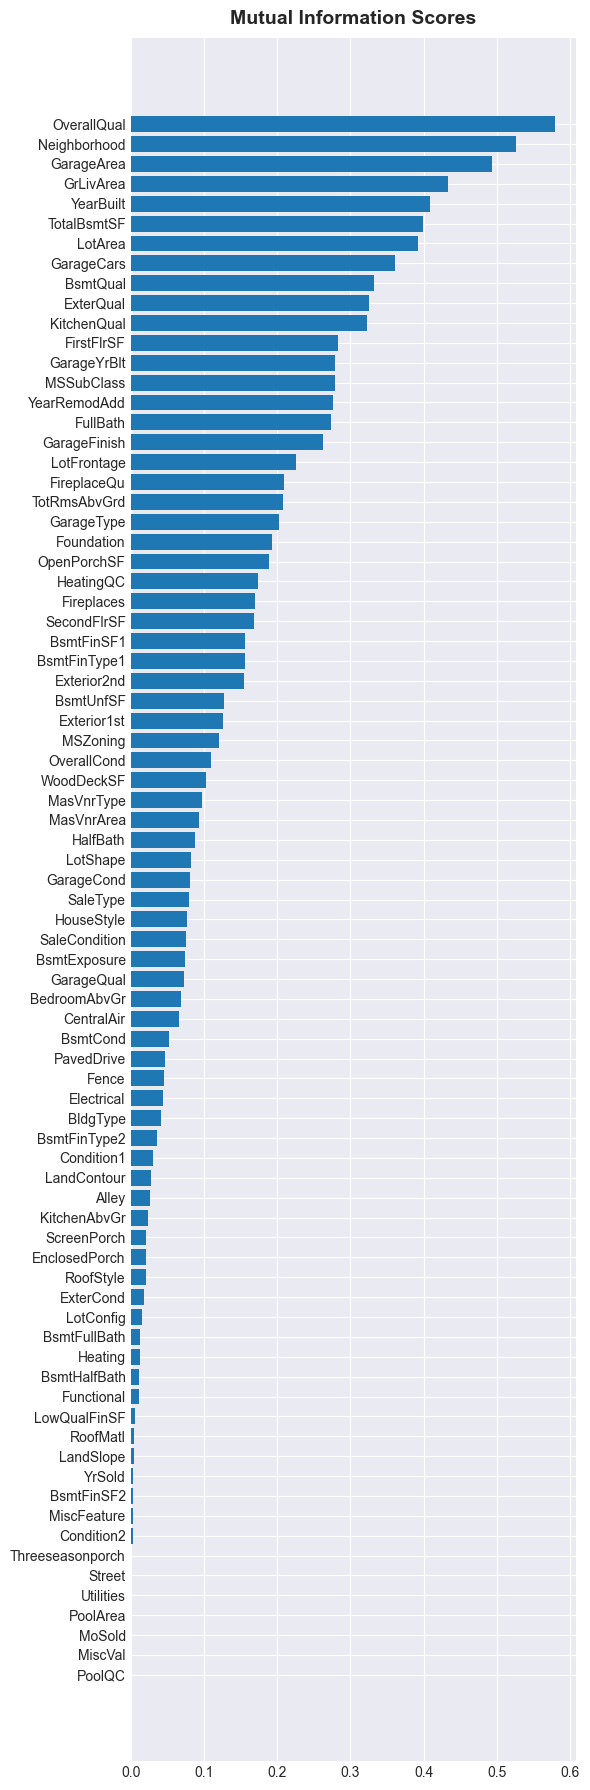

In [10]:
# Looking at MI
X = df_train.copy()
y = X.pop("SalePrice")

plt.figure(figsize=(6,18))
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

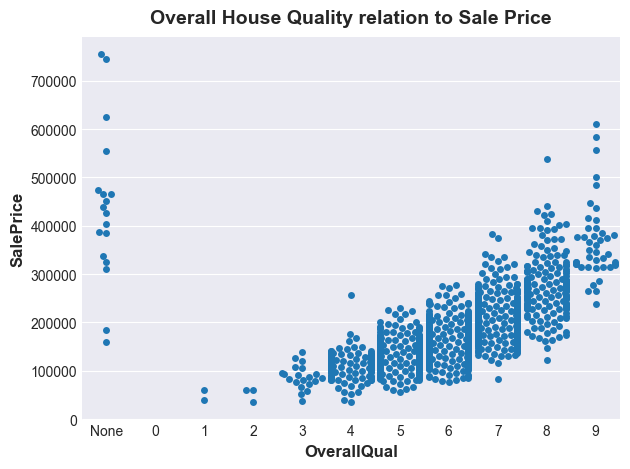

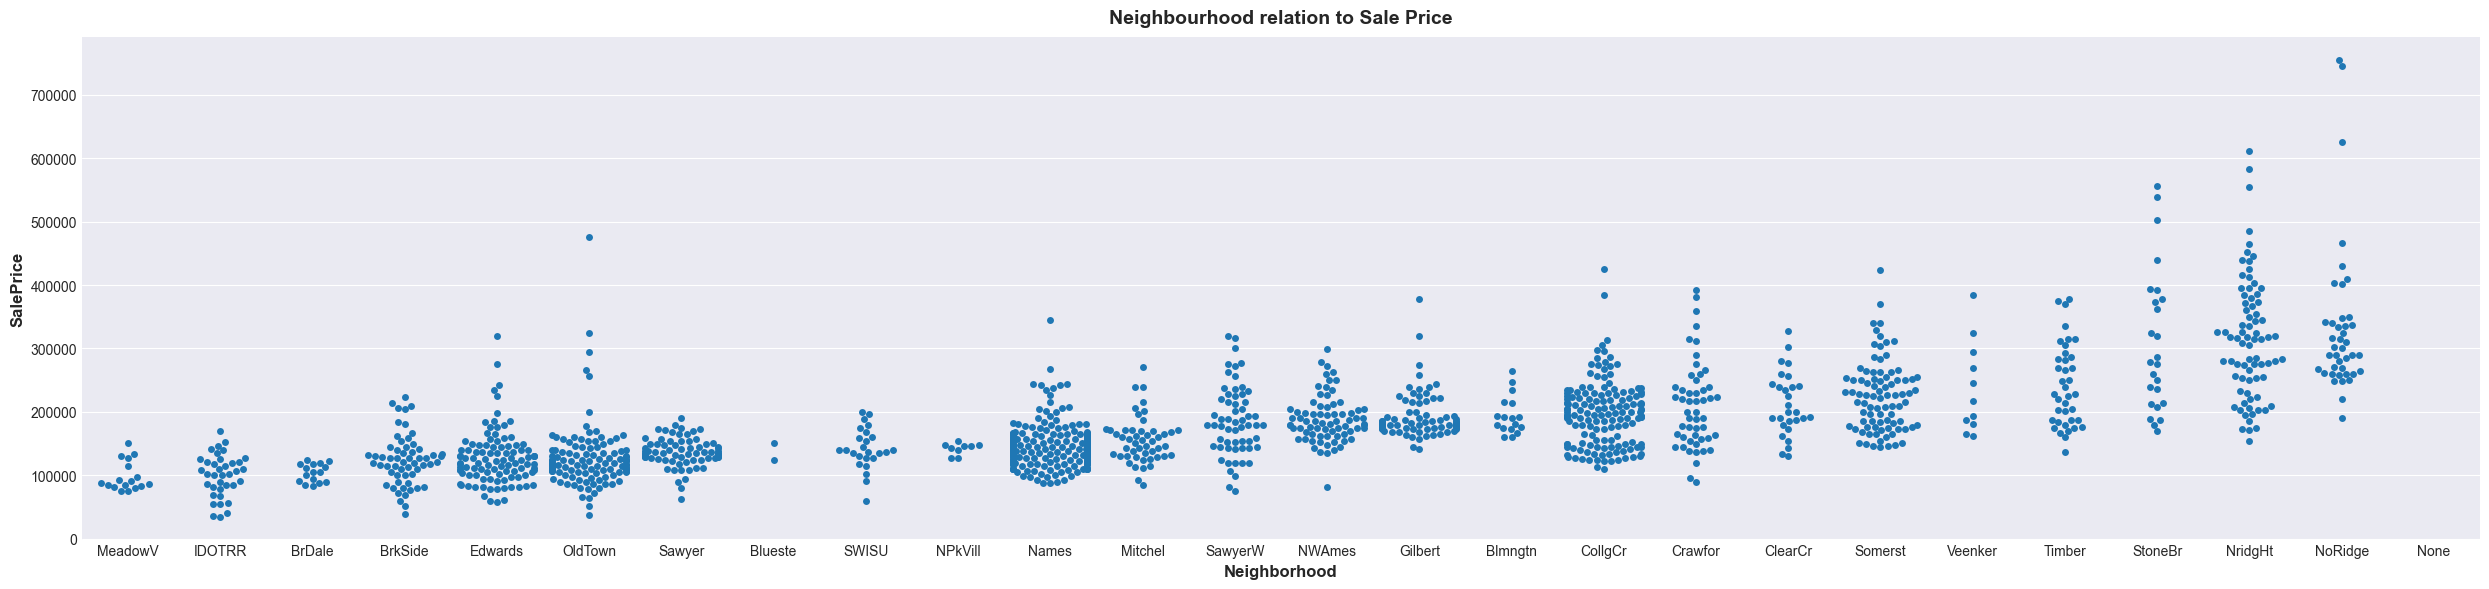

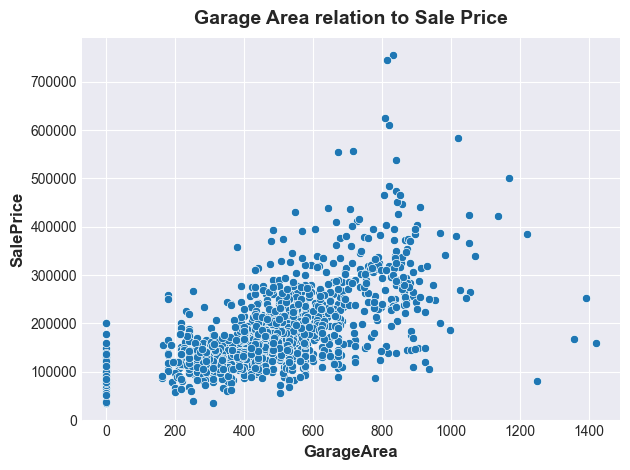

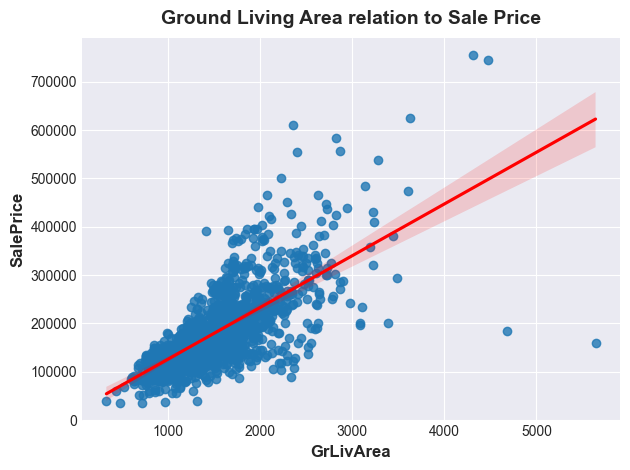

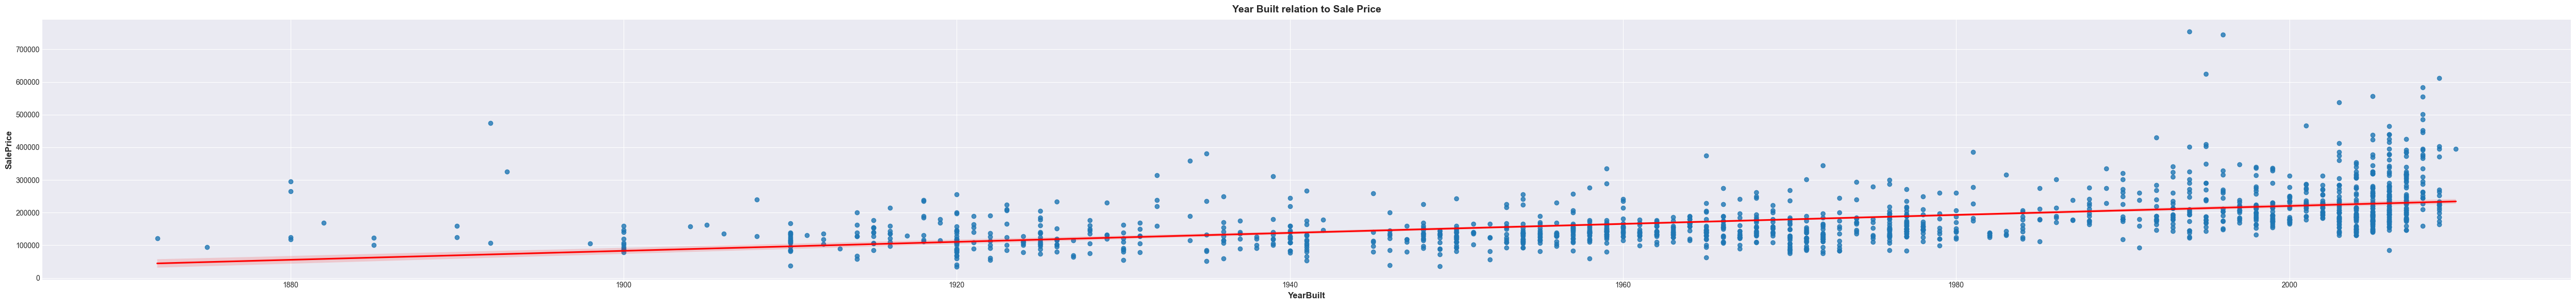

In [11]:
# Lets look at top 5 features (in terms of MI)

# Swarm for categorical, scatter for numerical, regplot for numerical + line of best fit
sns.swarmplot(x=X['OverallQual'],y=y).set_title("Overall House Quality relation to Sale Price") # Clear trend towards more expensive houses
plt.show()
plt.figure(figsize=(25,6))

# Calculate the mean sale price for each neighborhood
neighborhood_means = df_train.groupby('Neighborhood', dropna=False)['SalePrice'].mean().sort_values()
# Get an ordered list of neighborhoods
ordered_neighborhoods = neighborhood_means.index.tolist()

sns.swarmplot(x=X['Neighborhood'],y=y, order=ordered_neighborhoods).set_title("Neighbourhood relation to Sale Price") 
plt.show()
# Very few houses in Blueste, NPkVill, and Veenker.
# Could be worth binning this so that we have economic categories like (poor:middling:wealthy) or similar. But worth not removing Neighborhood as is - PCA could be useful.
# For instance, a big house might be worth more in a neighborhood where most houses are small & cheap, the difference in price relative to the mean of the neighborhood is worth looking at.

sns.scatterplot(x=X['GarageArea'],y=y).set_title("Garage Area relation to Sale Price") # Clear trend towards more expensive houses
plt.show()

sns.regplot(x=X['GrLivArea'],y=y, fit_reg=True, line_kws={"color": "red"}).set_title("Ground Living Area relation to Sale Price") # More living area higher cost - check out those two datapoints with an extremely low price for its living area.
plt.show()

plt.figure(figsize=(50,6))
sns.regplot(x=X['YearBuilt'],y=y, line_kws={"color": "red"}).set_title("Year Built relation to Sale Price") # Newer houses trend more expensive, go figure. This means yr sold relates to yr built, should create a house age feature.
plt.show()

## Establish Baseline ##

In [12]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [13]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14404 RMSLE


# Create Features #

 [Label encoding](https://www.kaggle.com/alexisbcook/categorical-variables) for the categorical features:

In [14]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

## Feature Engineering ##

In [35]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    #X["LivLotRatio"] = df.GrLivArea / df.LotArea # How much of the lot area is actual house area rather than external land. This wasn't useful.
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    X["OverallQualWithCond"] = pd.to_numeric(df['OverallQual'], errors='coerce') * pd.to_numeric(df['OverallCond'], errors='coerce') # Unclear whether this is useful yet
    X["TotBathrooms"] = df.FullBath + df.BsmtFullBath + (df.HalfBath*0.5) + (df.BsmtHalfBath*0.5) # Higher number of bathrooms generally means higher price
    X["HouseAge"] = pd.to_numeric(df.YrSold) - pd.to_numeric(df.YearRemodAdd) # Year remodelled is set to year built if the house hasn't been remodeled
    X["Remodelled"] = np.where(pd.to_numeric(df["YearRemodAdd"]) != pd.to_numeric(df["YearBuilt"]), True, False) # This didn't seem particularly helpful, False leads to slightly more expensive houses but barely
    X["OverallSF"] = df.GrLivArea + df.TotalBsmtSF
    #X["IsNew"] = np.where(df.YrSold == df.YearBuilt, True, False) # Less useful than expected
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["Porches"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
        #"Fireplaces"
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median") # Big houses in certain neighbourhoods will be much more expensive than others
    X["MedZoneArea"] = df.groupby("MSZoning")["GrLivArea"].transform("median") # Big houses in certain types of area will be much more expensive than others
    return X

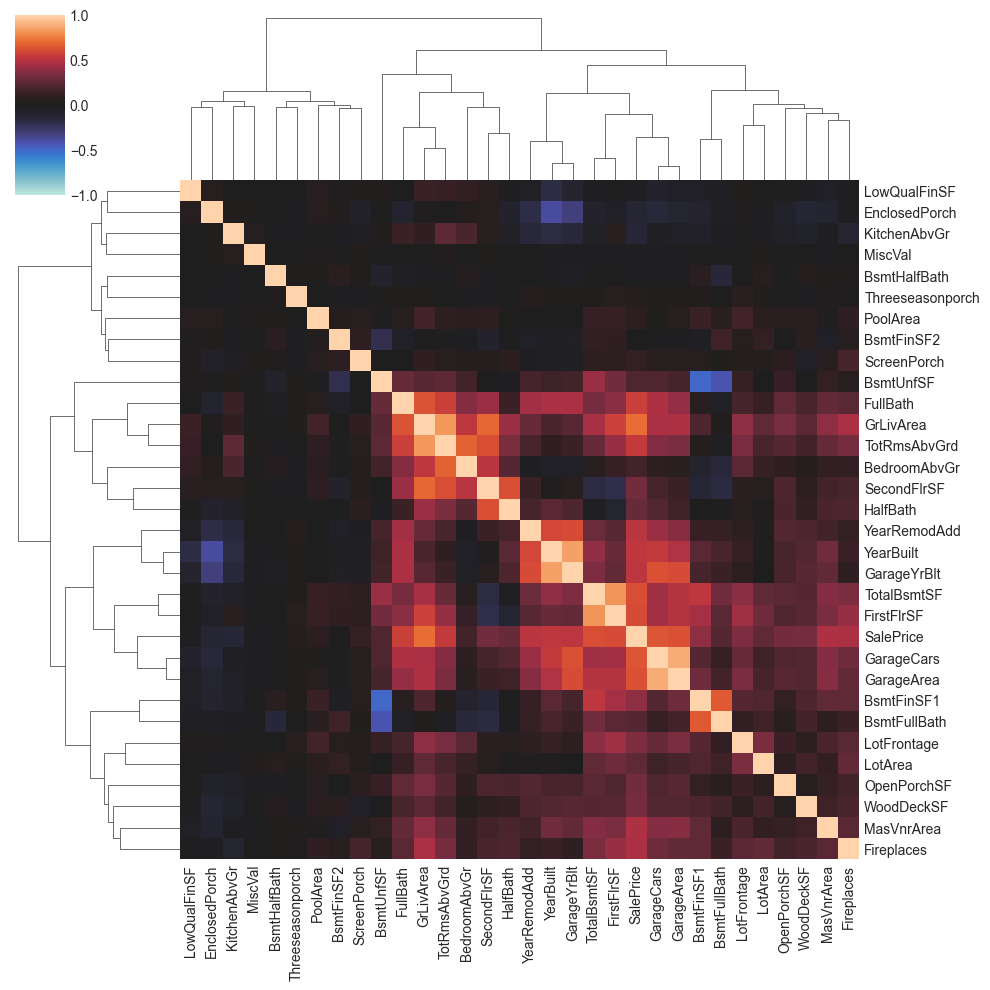

In [36]:
# More investigating to do here
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

### Indicate Outliers ###

In [37]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial") # These are the two houses with absolutely massive GrLivArea for a very low saleprice
    return X_new

## Target Encoding ##

In [42]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

## Create Final Feature Set ##

In [43]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Do processing separately to avoid data leakage
    if df_test is not None:
        X_test = df_test.copy()
        #X_test.pop("SalePrice") # Sale price doesn't exist in df_test, why was this here...
        
        # Mutual Information
        #X_test = drop_uninformative(X_test, mi_scores)
    
        # Transformations
        X_test = X_test.join(mathematical_transforms(X_test))
        X_test = X_test.join(interactions(X_test))
        X_test = X_test.join(counts(X_test))
        # X_test = X_test.join(break_down(X_test))
        X_test = X_test.join(group_transforms(X_test))

        # Mark outliers
        X_test = X_test.join(indicate_outliers(X_test))
    
        X_test = label_encode(X_test)

    # Mutual Information
    #X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Mark outliers
    X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]
y_train

score_dataset(X_train, y_train)

np.float64(0.13779455275693941)

## Analysis of New Features ##

Correlation between House Age and SalePrice is:  -0.51


<Figure size 600x600 with 0 Axes>

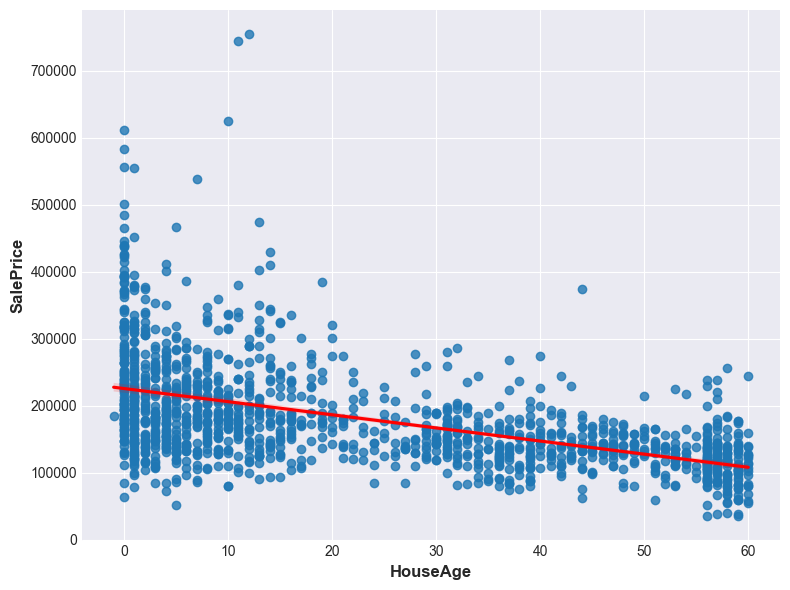

Correlation between TotBathrooms and SalePrice is:  0.63


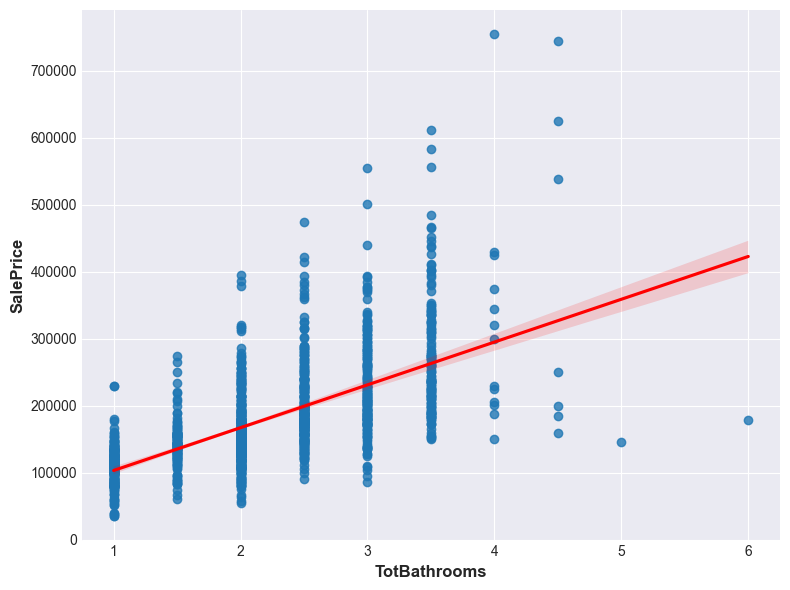

Correlation between Spaciousness and SalePrice is:  0.55


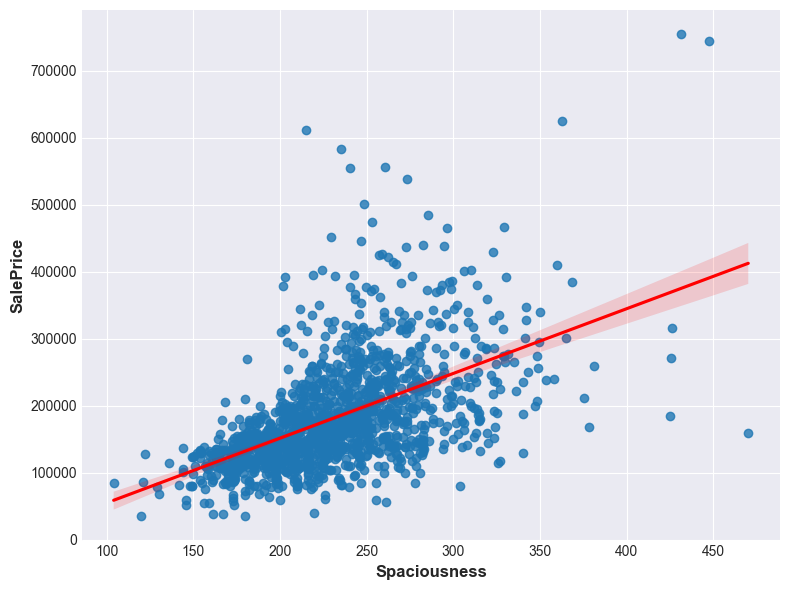

Correlation between OverallSF and SalePrice is:  0.78


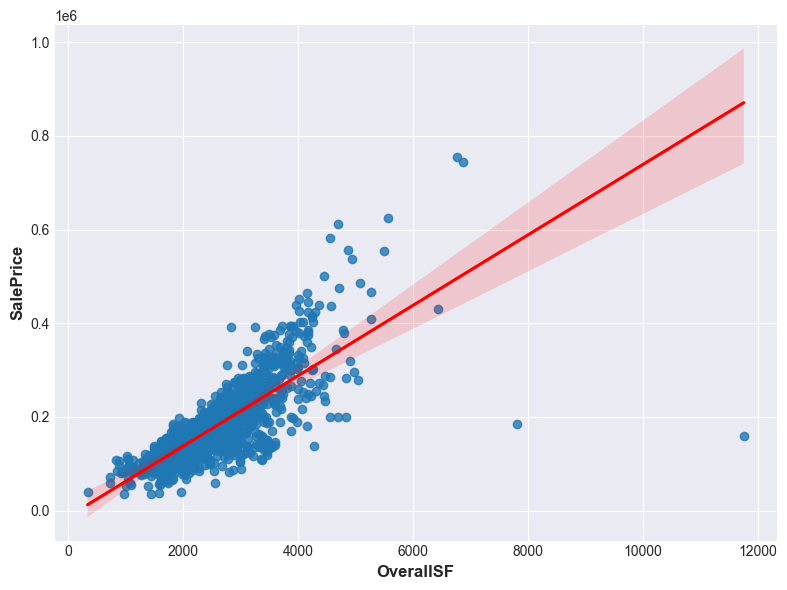

Correlation between MedNhbdArea and SalePrice is:  0.65


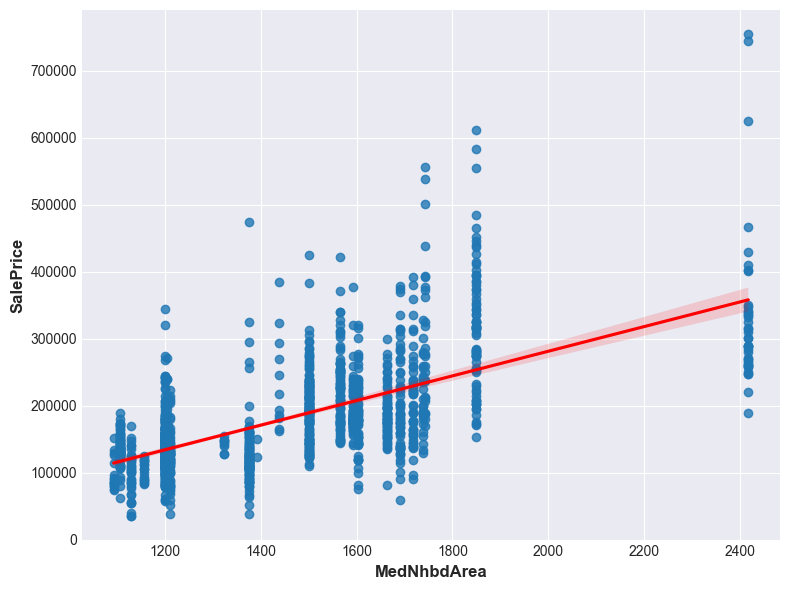

In [44]:
plt.figure(figsize=(6,6))
#mi_scores = make_mi_scores(X_train[['HouseAge', 'Remodelled', 'TotBathrooms', 'MasVnrArea_Log', 'Spaciousness', 'LivLotRatio']], y_train)
#plot_mi_scores(mi_scores)

plt.figure(figsize=(8,6))
sns.regplot(x=X_train['HouseAge'], y=y_train, line_kws={"color": "red"})
corr = X_train['HouseAge'].corr(y_train)
print("Correlation between House Age and SalePrice is: ", round(corr, 2))
plt.show()

plt.figure(figsize=(8,6))
sns.regplot(x=X_train['TotBathrooms'], y=y_train, line_kws={"color": "red"})
corr = X_train['TotBathrooms'].corr(y_train)
print("Correlation between TotBathrooms and SalePrice is: ", round(corr, 2))
plt.show()

plt.figure(figsize=(8,6))
sns.regplot(x=X_train['Spaciousness'], y=y_train, line_kws={"color": "red"})
corr = X_train['Spaciousness'].corr(y_train)
print("Correlation between Spaciousness and SalePrice is: ", round(corr, 2))
plt.show()


plt.figure(figsize=(8,6))
sns.regplot(x=X_train['OverallSF'], y=y_train, line_kws={"color": "red"})
corr = X_train['OverallSF'].corr(y_train)
print("Correlation between OverallSF and SalePrice is: ", round(corr, 2))
plt.show()

# Dropped it, no longer used
#plt.figure(figsize=(4,4))
#sns.barplot(x=X_train['Remodelled'], y=y_train)
#plt.show()

#plt.figure(figsize=(8,6))
#sns.regplot(x=X_train['Porches'], y=y_train, line_kws={"color": "red"})
#corr = X_train['Porches'].corr(y_train)
#print("Correlation between Porches and SalePrice is: ", round(corr, 2))
#plt.show()

#plt.figure(figsize=(8,6))
#sns.regplot(x=X_train['IsNew'], y=y_train, line_kws={"color": "red"})
#corr = X_train['IsNew'].corr(y_train)
#print("Correlation between IsNew and SalePrice is: ", round(corr, 2))
#plt.show()

plt.figure(figsize=(8,6))
sns.regplot(x=X_train['MedNhbdArea'], y=y_train, line_kws={"color": "red"})
corr = X_train['MedNhbdArea'].corr(y_train)
print("Correlation between MedNhbdArea and SalePrice is: ", round(corr, 2))
plt.show()

# Hyperparameter Tuning #

In [45]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
import time # for checking how long different methods take

X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

# Searchspace for later - This should be taken with a massive grain of salt, I did the classic error of spending too long on hyperparameter tuning to get the best score on the validation set, only for the actual score on the test set to be worse
# and in different directions. i.e lets say setting max depth to 5 increases the score given on the validation set, it may decrease the score on the test set.
# Experimenting with different scoring methods, as well as developing a better understanding of all of these parameters and how they affect models would be prudent.
xgb_little_params = dict( 
    # These values below should be in lists as the [] implies so that they can be searched over a range you give it, currently no ranges are in-place
    max_depth=[3],    # maximum depth of each tree - linear range from 2 to 10, best found so far is 3
    learning_rate=[0.1],    # effect of each tree - logarithmic range from 0.001 to 0.1, best found so far is 0.1
    n_estimators=[6500], # number of trees - logarithmic range from 1000 to 8000, best found so far is 6500
    min_child_weight=[3],    # minimum number of houses in a leaf - linear range from 1 to 10, best found so far is 3
    colsample_bytree=[0.2],    # fraction of features per tree - linear range from 0.2 to 1.0, best found so far is 0.2
    subsample=[0.7],    # fraction of instances per tree - linear range from 0.2 to 1.0, best found so far is 0.7
    reg_alpha=[0.5],    # L1 regularization - logarithmic range from 0.001 to 10.0, best found so far is 0.5
    reg_lambda=[1.0],    # L2 regularization - logarithmic range from 0.001 to 10.0, best found so far is 1.0
    num_parallel_tree=[5],    # set > 1 for boosted random forests, best found so far is 5
)

# Using XGBRegressor because it's apparently quite good at this problem. Should try out Lasso for the same reason
xgb = XGBRegressor()

# Set up HalvingGridSearchCV
#search_halving = HalvingGridSearchCV(xgb, xgb_params, cv=5, resource='n_samples', aggressive_elimination=True)

# Set up HalvingRandomSearchCV, faster than HalvingGridSearchCV and generally just as good
#search_halving_random = HalvingRandomSearchCV(xgb, xgb_little_params, cv=5)

# Fit the data
#search_halving_random.fit(X_train, y_train)

In [46]:
# Investigating values which weren't immediately readable
#print("\nBest num_parallel_tree value:", search_halving_random.best_params_['num_parallel_tree'])

In [47]:
# Actual used parameters, values aren't always set to best values due to hand-tuning finding better later
xgb_params = dict(
    max_depth=3,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=6500,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=2,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.21,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=2,   # set > 1 for boosted random forests
)

score_dataset(X_train, y_train, XGBRegressor(**xgb_params))

np.float64(0.1174500296896261)

# Train Model and Create Submission #

In [48]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Submission was successfully saved!")

Submission was successfully saved!
